<a href="https://colab.research.google.com/github/jeonghojo00/DeepPortfolio/blob/main/Portfolio_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

In [ ]:
pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import bs4 as bs
import requests
import datetime

In [24]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Change current directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepPortfolio')

### Download stock historical data of sp500 and others

In [5]:
##<script src="https://gist.github.com/paduel/32ac6f0a47f3fae67e414a73b9779e89.js"></script>
sp_assets = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500 = sp_assets.Symbol.tolist()

In [6]:
# Modify tickers
sp500 = ['BRK-B' if ticker=='BRK.B' else ticker for ticker in sp500]
sp500 = ['BF-B' if ticker=='BF.B' else ticker for ticker in sp500]
etfs = ["SPY", "DIA", "QQQ", "TAN", "VWO", "NOBL", "ARKK"]
not_sp500 = ['TDOC', 'VMW', 'MAIN', 'TWLO', 'BABA', 'LULU', 'ZS', 'ABR', 'SDGR', 'PLTR', 'ABB']
ticker_list = sp500+etfs+not_sp500
ticker_list = list(set(ticker_list))
print("Total {} tickers: {} SP500 companies, {} not-SP500 companies, and {} ETFs".format(len(ticker_list), len(sp500), len(not_sp500), len(etfs)))

Total 523 tickers: 505 SP500 companies, 11 not-SP500 companies, and 7 ETFs


In [ ]:
start = '2011-01-01'
end = None
data = yf.download(ticker_list, start=start, end=end, as_panel=False)


[*********************100%***********************]  523 of 523 completed


### Save data file as pickle

In [ ]:
filename = 'data/sp500_components_data.pkl'
data.to_pickle(filename)
print('Data saved at {}'.format(filename))

Data saved at data/sp500_components_data.pkl


### Read Pickle file of Stock Data

In [7]:
import pandas as pd
filename = 'data/sp500_components_data.pkl'
prices = pd.read_pickle(filename)

In [8]:
prices["Adj Close"]["SPY"]

Date
2010-12-31           NaN
2011-01-03    103.779396
2011-01-04    103.722198
2011-01-05    104.261322
2011-01-06    104.057114
                 ...    
2021-05-24    419.170013
2021-05-25    418.239990
2021-05-26    419.070007
2021-05-27    419.290009
2021-05-28    420.040009
Name: SPY, Length: 2623, dtype: float64

### Read Stock Order file

In [26]:
orders_file="data/stock_orders.csv"
orders_df = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])  

# Process Stock orders processes

In [27]:
commission=0
impact=0.005

orders_df = orders_df.replace({'Order': {'BUY': 1, 'SELL': -1}})
orders_df["Change"] = orders_df["Order"] * orders_df["Shares"]
orders_df["Traded"] = 1
orders_df["Commission"] = commission
start_date = orders_df.index.min()
end_date = orders_df.index.max()
listPort = orders_df.Symbol.unique()	

In [28]:
dates = pd.date_range(start_date, end_date)
stock_prices = prices["Adj Close"][listPort].loc[start_date:]

In [29]:
stock_prices = stock_prices.fillna(method='ffill')
stock_prices = stock_prices.fillna(method='bfill')
stock_prices["Cash"] = 1

In [37]:
# Make Orders dataframe
orderStocks = pd.DataFrame(data=0, index=stock_prices.index, columns=stock_prices.columns)
orderStocks["Cash"] = 0
for symbol in listPort:
    orders = orders_df[orders_df.Symbol == symbol]
    orders = orders.sort_index()
    orders = orders.rename({"Change": symbol}, axis='columns')
    orders = orders.drop(['Symbol', 'Order', 'Shares'], axis=1)
    
    dates = orders.index.date
    orders["Traded"] = -orders[symbol] * stock_prices.loc[dates, symbol]
    orders["Impact"] = abs(orders["Traded"]) * impact

    orders = orders.groupby(by="Date").sum()
    orderStocks.loc[dates, symbol] = orders[symbol]
    orderStocks.loc[dates, "Cash"] += orders["Traded"] - orders["Commission"] - orders["Impact"]



In [40]:
import copy 

start_val=0

# Make Holding dataframe
holdingStocks = copy.deepcopy(orderStocks)
holdingStocks = holdingStocks.cumsum()
holdingStocks["Cash"] = holdingStocks["Cash"] + start_val



In [62]:
# Make Values dataframe and Portfolio value dataframe
valuesStocks = stock_prices * holdingStocks
portVals = valuesStocks.sum(axis=1)
totVals = valuesStocks.iloc[:,:-1].sum(axis=1)
print('print valueStocks')
print(valuesStocks)
print('Current Profit')
print(portVals[-1])
print('Total Stock Asset')
print(totVals[-1])

print valueStocks
                    MSFT        BRK-B  ...          TAN           Cash
Date                                   ...                            
2018-08-13   3646.224174     0.000000  ...     0.000000   -3664.455295
2018-08-14   3691.713600     0.000000  ...     0.000000   -3664.455295
2018-08-15   3641.651840     0.000000  ...     0.000000   -3664.455295
2018-08-16   3640.975723     0.000000  ...     0.000000   -3664.455295
2018-08-17   3638.946838     0.000000  ...     0.000000   -3664.455295
...                  ...          ...  ...          ...            ...
2021-05-24  23573.319885  1448.650055  ...  1556.000061 -372485.592410
2021-05-25  23661.680115  1436.000061  ...  1548.999939 -372485.592410
2021-05-26  23640.060516  1436.649933  ...  1586.199951 -372485.592410
2021-05-27  23435.139771  1446.499939  ...  1586.399994 -372485.592410
2021-05-28  23469.919312  1447.200012  ...  1582.200012 -372485.592410

[705 rows x 34 columns]
Current Profit
219726.321044233
To

# Plot the Portfolio values and profits

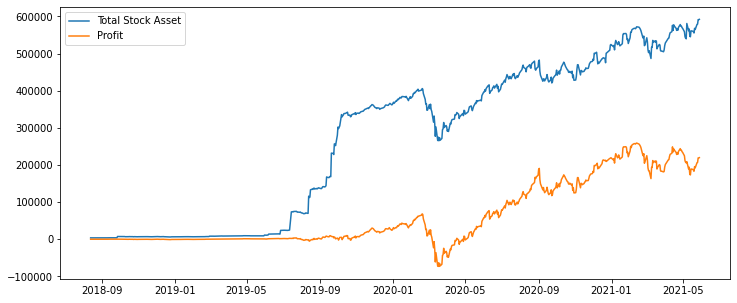

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(totVals, label="Total Stock Asset")
plt.plot(portVals, label="Profit")
plt.legend(loc='best')

In [ ]:
def compute_portvals(  		  	   		     		  		  		    	 		 		   		 		  
    orders_file="./orders/orders.csv",  		  	   		     		  		  		    	 		 		   		 		  
    start_val=1000000,  		  	   		     		  		  		    	 		 		   		 		  
    commission=9.95,  		  	   		     		  		  		    	 		 		   		 		  
    impact=0.005,  		  	   		     		  		  		    	 		 		   		 		  
):  		  	   		     		  		  		    	 		 		   		 		  
    """  		  	   		     		  		  		    	 		 		   		 		  
    Computes the portfolio values.  		  	   		     		  		  		    	 		 		   		 		  
  		  	   		     		  		  		    	 		 		   		 		  
    :param orders_file: Path of the order file or the file object  		  	   		     		  		  		    	 		 		   		 		  
    :type orders_file: str or file object  		  	   		     		  		  		    	 		 		   		 		  
    :param start_val: The starting value of the portfolio  		  	   		     		  		  		    	 		 		   		 		  
    :type start_val: int  		  	   		     		  		  		    	 		 		   		 		  
    :param commission: The fixed amount in dollars charged for each transaction (both entry and exit)  		  	   		     		  		  		    	 		 		   		 		  
    :param impact: The amount the price moves against the trader compared to the historical data at each transaction  		  	   		     		  		  		    	 		 		   		 		  
    :type impact: float  		  	   		     		  		  		    	 		 		   		 		  
    :return: the result (portvals) as a single-column dataframe, containing the value of the portfolio for each trading day in the first column from start_date to end_date, inclusive.  		  	   		     		  		  		    	 		 		   		 		  
    :rtype: pandas.DataFrame  		  	   		     		  		  		    	 		 		   		 		  
    """  		  	   		     		  		  		    	 		 		   		 		  
    # this is the function the autograder will call to test your code  		  	   		     		  		  		    	 		 		   		 		  
    # NOTE: orders_file may be a string, or it may be a file object. Your  		  	   		     		  		  		    	 		 		   		 		  
    # code should work correctly with either input  		  	   		     		  		  		    	 		 		   		 		  
    # TODO: Your code here  		  	   		     		  		  		    	 		 		   		 		  
    
    # Read Orders file
    orders_df = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])  
    orders_df = orders_df.replace({'Order': {'BUY': 1, 'SELL': -1}})
    orders_df["Change"] = orders_df["Order"] * orders_df["Shares"]
    orders_df["Traded"] = 1
    orders_df["Commission"] = commission
    start_date = orders_df.index.min()
    end_date = orders_df.index.max()
    listPort = orders_df.Symbol.unique()		  		  		    	 		 		   		 		  	  	   		     		 

    # Make Stock Price dataframe
    stockPrices = get_data(["SPY"], pd.date_range(start_date, end_date))  

    for symbol in listPort:
        portvals = get_data([symbol], pd.date_range(start_date, end_date))    	   		     		  		  		    	 		 		   		 		  
        portvals = portvals[[symbol]]  # remove SPY
        stockPrices = stockPrices.join(portvals)
    
    stockPrices = stockPrices.drop(columns=['SPY'])
    stockPrices = stockPrices.fillna(method='ffill')
    stockPrices["Cash"] = 1
    
    # Make Orders dataframe
    orderStocks = copy.deepcopy(stockPrices)
    orderStocks = orderStocks.replace(orderStocks, 0)
    orderStocks["Cash"] = 0
    for symbol in listPort:
        orders = orders_df[orders_df.Symbol == symbol]
        orders = orders.sort_index()
        orders = orders.rename({"Change": symbol}, axis='columns')
        orders = orders.drop(['Symbol', 'Order', 'Shares'], axis=1)

        dates = orders.index.date
        orders["Traded"] = -orders[symbol] * stockPrices.loc[dates, symbol]
        orders["Impact"] = abs(orders["Traded"]) * impact

        orders = orders.groupby(by="Date").sum()
        orderStocks.loc[dates, symbol] = orders[symbol]
        orderStocks.loc[dates, "Cash"] += orders["Traded"] - orders["Commission"] - orders["Impact"]

    # Make Holding dataframe
    holdingStocks = copy.deepcopy(orderStocks)
    holdingStocks = holdingStocks.cumsum()
    holdingStocks["Cash"] = holdingStocks["Cash"] + start_val

    # Make Values dataframe and Portfolio value dataframe
    valuesStocks = stockPrices * holdingStocks
    portVals = valuesStocks.sum(axis=1)
    print('print valueStocks')
    print(valuesStocks)
    print('print portfolio values')
    print(portVals)
    return portVals  